# 1.Setup

In [34]:
import config
import os
from zipfile import ZipFile
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

2.3.0


# 2.数据加载、探索 

## 2.1 数据下载

In [35]:
zip_path = keras.utils.get_file(origin = config.zip_data_dir, fname = "jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()

## 2.2 数据加载

In [36]:
df = pd.read_csv(config.data_dir)
print(df.head())
print(df.shape)

             Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
0  01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
1  01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
2  01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31    93.9   
3  01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07    94.2   
4  01.01.2009 00:50:00    996.51     -8.27    265.15        -9.04    94.1   

   VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
0          3.33          3.11          0.22       1.94             3.12   
1          3.23          3.02          0.21       1.89             3.03   
2          3.21          3.01          0.20       1.88             3.02   
3          3.26          3.07          0.19       1.92             3.08   
4          3.27          3.08          0.19       1.92             3.09   

   rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  
0       1307.75      1.03        

## 2.3 数据探索

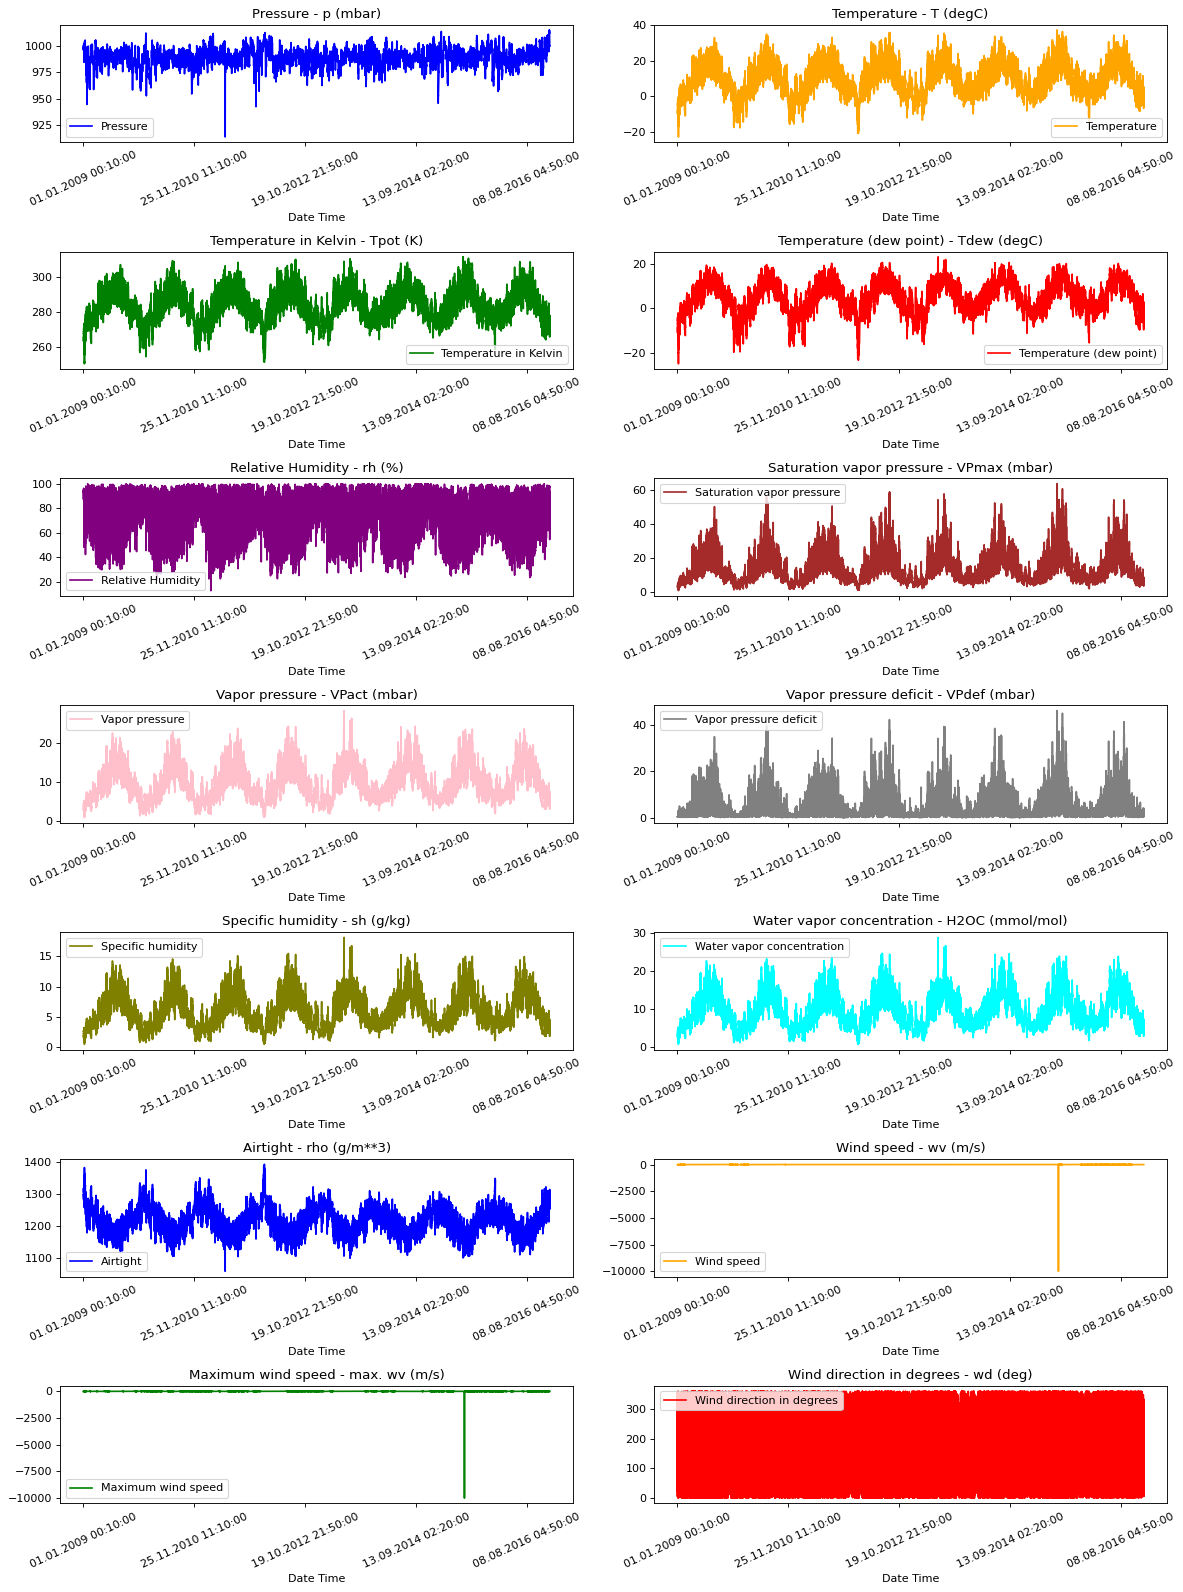

In [37]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "Date Time"


def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(nrows = 7, ncols = 2, figsize = (15, 20), dpi = 80, facecolor = "w", edgecolor = "k")
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(ax = axes[i // 2, i % 2], color = c, title = "{} - {}".format(titles[i], key), rot = 25)
        ax.legend([titles[i]])
    plt.tight_layout()

show_raw_visualization(df)

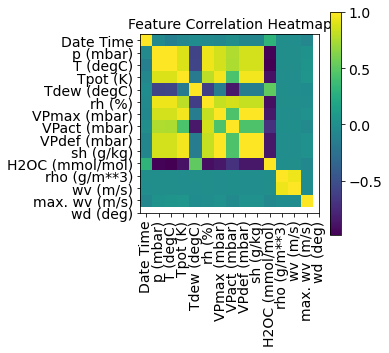

In [38]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize = 14, rotation = 90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize = 14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize = 14)
    plt.title("Feature Correlation Heatmap", fontsize = 14)
    plt.show()

show_heatmap(df)

# 3.数据预处理

In [56]:
# train and validation split fraction
split_fraction = 0.715
train_split = int(split_fraction * int(df.shape[0]))
print(train_split)
# model dataset params
step = 6
past = 720
future = 72
# model params
learning_rate = 0.001
batch_size = 256
epochs = 10

300693


## 3.1 特征筛选

In [40]:
selected_features = [feature_keys[i] for i in [0, 1, 5, 7, 8, 10, 11]]
features = df[selected_features]
features.index = df[date_time_key]
features.head()

,p (mbar),T (degC),VPmax (mbar),VPdef (mbar),sh (g/kg),rho (g/m**3),wv (m/s)
Date Time,,,,,,,
01.01.2009 00:10:00,996.52,-8.02,3.33,0.22,1.94,1307.75,1.03
01.01.2009 00:20:00,996.57,-8.41,3.23,0.21,1.89,1309.80,0.72
01.01.2009 00:30:00,996.53,-8.51,3.21,0.20,1.88,1310.24,0.19
01.01.2009 00:40:00,996.51,-8.31,3.26,0.19,1.92,1309.19,0.34
01.01.2009 00:50:00,996.51,-8.27,3.27,0.19,1.92,1309.00,0.32


## 3.2 数据标准化

In [55]:
def normalize(data, train_split):
    """
    使用训练数据 mean, std 进行标准化
    """
    data_mean = data[:train_split].mean(axis = 0)
    data_std = data[:train_split].std(axis = 0)
    normalized_data = (data - data_mean) / data_std
    return normalized_data

In [42]:
features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

,0,1,2,3,4,5,6
0,0.955451,-2.000020,-1.319782,-0.788479,-1.500927,2.237658,-0.732997
1,0.961528,-2.045185,-1.332806,-0.790561,-1.519521,2.287838,-0.936002
2,0.956666,-2.056766,-1.335410,-0.792642,-1.523239,2.298608,-1.283076
3,0.954236,-2.033604,-1.328898,-0.794724,-1.508364,2.272906,-1.184847
4,0.954236,-2.028972,-1.327596,-0.794724,-1.508364,2.268256,-1.197944


## 3.3 数据集分割

In [47]:
train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]
print(train_data.shape)
print(val_data.shape)

(300693, 7)
(119858, 7)


## 3.4 训练数据集构造

In [63]:
start = past + future
end = start + train_split
print(start)
print(end)

x_train = train_data[[i for i in range(7)]].values
y_train = features.iloc[start:end][[1]]
print(x_train.shape)
print(y_train.shape)

sequence_length = int(past / step)
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length = sequence_length,
    sampling_rate = step,
    batch_size = batch_size,
)

792
301485
(300693, 7)
(300693, 1)


## 3.5 验证数据集构造

In [64]:
x_end = len(val_data) - past - future
label_start = train_split + past + future
print(x_end)
print(label_start)

x_val = val_data.iloc[:x_end][[i for i in range(7)]].values
y_val = features.iloc[label_start:][[1]]
print(x_val.shape)
print(y_val.shape)

sequence_length = int(past / step)
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length = sequence_length,
    sampling_rate = step,
    batch_size = batch_size,
)

119066
301485
(119066, 7)
(119066, 1)


# 4.模型构建

In [67]:
for batch in dataset_train.take(1):
    inputs, targets = batch
print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

inputs = keras.layers.Input(shape = (inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)
model = keras.Model(inputs = inputs, outputs = outputs)

Input shape: (256, 120, 7)
Target shape: (256, 1)


# 5.模型编译、训练

## 5.1 模型编译

In [69]:
model.compile(optimizer = keras.optimizers.Adam(learning_rate = learning_rate), loss = "mse")
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 120, 7)]          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                5120      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 5,153
Trainable params: 5,153
Non-trainable params: 0
_________________________________________________________________


## 5.2 模型训练

In [70]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor = "val_loss", min_delta = 0, patience = 5)
modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor = "val_loss",
    filepath = path_checkpoint,
    verbose = 1,
    save_weights_only = True,
    save_best_only = True,
)
history = model.fit(
    dataset_train,
    epochs = epochs,
    validation_data = dataset_val,
    callbacks = [es_callback, modelckpt_callback],
)

Epoch 1/10
1171/1172 [============================>.] - ETA: 0s - loss: 0.1898
Epoch 00001: val_loss improved from inf to 0.15725, saving model to model_checkpoint.h5
1172/1172 [==============================] - 78s 66ms/step - loss: 0.1897 - val_loss: 0.1573
Epoch 2/10
1171/1172 [============================>.] - ETA: 0s - loss: 0.1260
Epoch 00002: val_loss improved from 0.15725 to 0.14416, saving model to model_checkpoint.h5
1172/1172 [==============================] - 77s 66ms/step - loss: 0.1260 - val_loss: 0.1442
Epoch 3/10
1171/1172 [============================>.] - ETA: 0s - loss: 0.1160
Epoch 00003: val_loss did not improve from 0.14416
1172/1172 [==============================] - 77s 66ms/step - loss: 0.1159 - val_loss: 0.1456
Epoch 4/10
1172/1172 [==============================] - ETA: 0s - loss: 0.1118
Epoch 00004: val_loss improved from 0.14416 to 0.13940, saving model to model_checkpoint.h5
1172/1172 [==============================] - 79s 68ms/step - loss: 0.1118 - val_lo

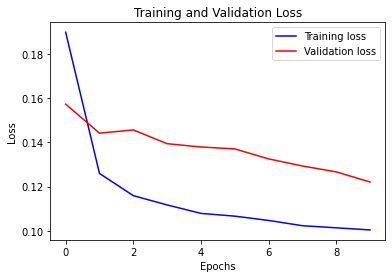

In [74]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

## 5.3 模型预测

In [75]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return

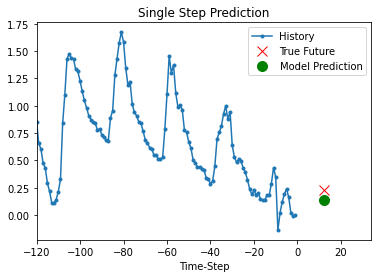

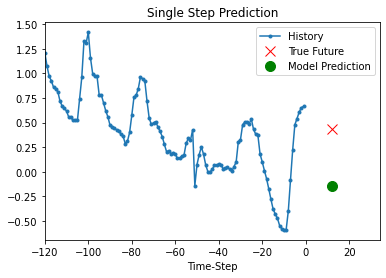

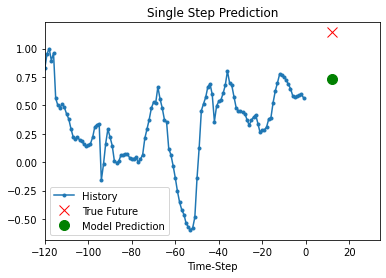

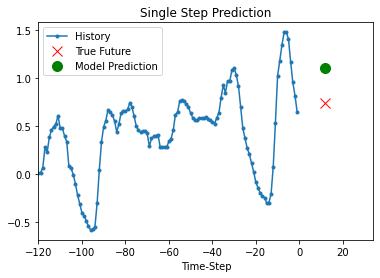

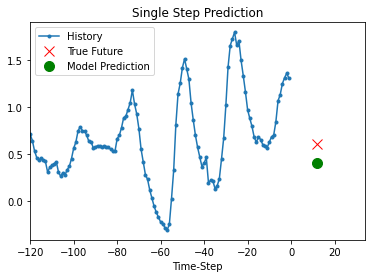

In [76]:
for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )